<a href="https://colab.research.google.com/github/xmxhuihui/Self-driving-Car-Project/blob/master/Object_Detection_ipynb(basic)(epoch%3D15000).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

import tensorflow as tf
print(tf.__version__)
import os

TensorFlow 1.x selected.
1.15.2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Number of training steps.
num_steps = 1000  # 200000
#num_steps = 100  # 200000

# Number of evaluation steps.
num_eval_steps = 50
# model configs are from Model Zoo github: 
# https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models
MODELS_CONFIG = {
    #http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_quantized_300x300_coco14_sync_2018_07_18.tar.gz
    'ssd_mobilenet_v1_quantized': {
        'model_name': 'ssd_mobilenet_v1_quantized_300x300_coco14_sync_2018_07_18',
        'pipeline_file': 'ssd_mobilenet_v1_quantized_300x300_coco14_sync.config',
        'batch_size': 12
    },    
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    },
    #http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_quantized_300x300_coco_2019_01_03.tar.gz
    'ssd_mobilenet_v2_quantized': {
        'model_name': 'ssd_mobilenet_v2_quantized_300x300_coco_2019_01_03',
        'pipeline_file': 'ssd_mobilenet_v2_quantized_300x300_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 12
    }
}
selected_model = 'ssd_mobilenet_v2_quantized'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

In [4]:
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git
!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk
!pip install -q Cython contextlib2 pillow lxml matplotlib
!pip install -q pycocotools
!pip install -U -q numpy==1.17.0
%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'
!python object_detection/builders/model_builder_test.py
    

/content
Selecting previously unselected package python-bs4.
(Reading database ... 144568 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unpack .../5-python-html5lib_0.999999999-1_all.deb ...
Unpa

In [5]:
# Convert train folder annotation xml files to a single csv file,
# generate the `label_map.pbtxt` file to `data/` directory as well.
%cd /content/drive/My Drive/Colab Notebooks
!python code/xml_to_csv.py -i Object -o annotations/train_labels.csv -l annotations

# Convert test folder annotation xml files to a single csv.
!python code/xml_to_csv.py -i Object -o annotations/test_labels.csv

# Generate `train.record`
!python code/generate_tfrecord.py --csv_input=annotations/train_labels.csv --output_path=annotations/train.record --img_path=Object --label_map annotations/label_map.pbtxt

# Generate `test.record`
!python code/generate_tfrecord.py --csv_input=annotations/test_labels.csv --output_path=annotations/test.record --img_path=Object --label_map annotations/label_map.pbtxt

/content/drive/My Drive/Colab Notebooks
Successfully converted xml to csv.
Generate `annotations/label_map.pbtxt`
Successfully converted xml to csv.


W0410 18:12:02.564190 140356980066176 module_wrapper.py:139] From code/generate_tfrecord.py:107: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0410 18:12:02.985155 140356980066176 module_wrapper.py:139] From /content/models/research/object_detection/utils/label_map_util.py:138: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/drive/My Drive/Colab Notebooks/annotations/train.record


W0410 18:12:31.331386 140310577948544 module_wrapper.py:139] From code/generate_tfrecord.py:107: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0410 18:12:31.741813 140310577948544 module_wrapper.py:139] From /content/models/research/object_detection/utils/label_map_util.py:138: The name t

In [6]:
test_record_fname = '/content/drive/My Drive/Colab Notebooks/annotations/test.record'
train_record_fname = '/content/drive/My Drive/Colab Notebooks/annotations/train.record'
label_map_pbtxt_fname = '/content/drive/My Drive/Colab Notebooks/annotations/label_map.pbtxt'
print(test_record_fname)
print(train_record_fname)
print(label_map_pbtxt_fname)

/content/drive/My Drive/Colab Notebooks/annotations/test.record
/content/drive/My Drive/Colab Notebooks/annotations/train.record
/content/drive/My Drive/Colab Notebooks/annotations/label_map.pbtxt


In [7]:
!cat annotations/train_labels.csv

filename,width,height,class,xmin,ymin,xmax,ymax
1582722545700_95_0.png,320,240,large female,179,68,238,223
1584031891105_90_35.png,320,240,small male,108,37,125,70
1584031891105_90_35.png,320,240,red light,122,10,130,32
1584031891105_90_35.png,320,240,left sign,135,16,143,32
1584029456776_90_0.png,320,240,small male,160,69,187,139
1584031273877_90_35.png,320,240,green light,129,10,138,42
1584031273877_90_35.png,320,240,left sign,147,17,160,44
1584029455744_90_0.png,320,240,small male,161,69,187,140
1582723269156_85_0.png,320,240,large male,111,62,164,236
1582723269156_85_0.png,320,240,large female,63,61,109,217
1584031274909_90_35.png,320,240,green light,126,13,139,51
1584031274909_90_35.png,320,240,left sign,146,21,161,53
1584031896275_90_0.png,320,240,small male,61,85,100,182
1584031896275_90_0.png,320,240,red light,122,10,132,34
1584031896275_90_0.png,320,240,left sign,138,17,149,35
1584031896275_90_0.png,320,240,small female,55,12,65,38
1582727151921_95_35.png,320,240,large male,12

In [8]:
!cat annotations/test_labels.csv

filename,width,height,class,xmin,ymin,xmax,ymax
1582722545700_95_0.png,320,240,large female,179,68,238,223
1584031891105_90_35.png,320,240,small male,108,37,125,70
1584031891105_90_35.png,320,240,red light,122,10,130,32
1584031891105_90_35.png,320,240,left sign,135,16,143,32
1584029456776_90_0.png,320,240,small male,160,69,187,139
1584031273877_90_35.png,320,240,green light,129,10,138,42
1584031273877_90_35.png,320,240,left sign,147,17,160,44
1584029455744_90_0.png,320,240,small male,161,69,187,140
1582723269156_85_0.png,320,240,large male,111,62,164,236
1582723269156_85_0.png,320,240,large female,63,61,109,217
1584031274909_90_35.png,320,240,green light,126,13,139,51
1584031274909_90_35.png,320,240,left sign,146,21,161,53
1584031896275_90_0.png,320,240,small male,61,85,100,182
1584031896275_90_0.png,320,240,red light,122,10,132,34
1584031896275_90_0.png,320,240,left sign,138,17,149,35
1584031896275_90_0.png,320,240,small female,55,12,65,38
1582727151921_95_35.png,320,240,large male,12

## Download Base Model

In [9]:
import os
import shutil
import glob
import urllib.request
import tarfile

%cd /content/models/research
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
    
tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [10]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 204M
drwx------  2 303230 5000 4.0K Jan  4  2019 .
drwxr-xr-x 63 root   root 4.0K Apr 10 18:12 ..
-rw-------  1 303230 5000  93M Jan  4  2019 model.ckpt.data-00000-of-00001
-rw-------  1 303230 5000  68K Jan  4  2019 model.ckpt.index
-rw-------  1 303230 5000  20M Jan  4  2019 model.ckpt.meta
-rw-------  1 303230 5000 4.3K Jan  4  2019 pipeline.config
-rw-------  1 303230 5000  24M Jan  4  2019 tflite_graph.pb
-rw-------  1 303230 5000  68M Jan  4  2019 tflite_graph.pbtxt


In [11]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

# Transfer Learning Training

In [0]:
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [0]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [14]:
import re  #regular expression

# training pipeline file defines:
# - pretrain model path
# - the train/test sets
# - ID to Label mapping and number of classes
# - training batch size
# - epochs to trains
# - learning rate
# - etc

# note we just need to use a sample one, and make edits to it.

num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint: downloaded pre-trained model checkpoint path
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test, we created earlier with our training/test sets
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path: ID to label file
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps (Number of epochs to train)
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [15]:
!cat "{label_map_pbtxt_fname}"

item {
    id: 1
    name: 'box'
}

item {
    id: 2
    name: 'green light'
}

item {
    id: 3
    name: 'large female'
}

item {
    id: 4
    name: 'large male'
}

item {
    id: 5
    name: 'left sign'
}

item {
    id: 6
    name: 'red light'
}

item {
    id: 7
    name: 'right sign'
}

item {
    id: 8
    name: 'small female'
}

item {
    id: 9
    name: 'small male'
}

item {
    id: 10
    name: 'tree'
}

In [16]:
!cat {pipeline_fname}

# Quantized trained SSD with Mobilenet v2 on MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 10
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        asp

In [17]:
num_steps = 15000
model_dir = '/content/drive/My Drive/Colab Notebooks/Training'
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir='{model_dir}' \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}
print("Training finished.")

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0410 18:12:56.310502 140583634872192 module_wrapper.py:139] From /content/models/research/object_detection/utils/config_util.py:102: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0410 18:12:56.313862 140583634872192 module_wrapper.py:139] From /content/models/research/object_detection/model_lib.py:628: The name tf.logging.warning is deprecated. Please use tf.compat.v1.logging.warning instead.

W0410 18:12:56.314010 140583634872192 model_lib.py:629] Forced number of epochs for all eval validations to be 1.

W0410 18:12:56.314150 140583634872192 module_wrapper.py:139] From /content/models/resea

# Save and Convert Model Output

In [0]:
import os
import re
import numpy as np

output_directory = '%s/fine_tuned_model' % model_dir
os.makedirs(output_directory, exist_ok=True)

In [19]:
lst = os.listdir(model_dir)
# find the last model checkpoint file, i.e. model.ckpt-1000.meta
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)

/content/drive/My Drive/Colab Notebooks/Training/model.ckpt-15000


In [20]:
!echo creates the frozen inference graph in fine_tune_model
# there is an "Incomplete shape" message.  but we can safely ignore that. 
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory='{output_directory}' \
    --trained_checkpoint_prefix='{last_model_path}'

creates the frozen inference graph in fine_tune_model
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0410 18:13:05.757200 140585230956416 module_wrapper.py:139] From /content/models/research/object_detection/export_inference_graph.py:145: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0410 18:13:05.763024 140585230956416 module_wrapper.py:139] From /content/models/research/object_detection/exporter.py:402: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W0410 18:13:05.763605 140585230956416 module_wrapper.py:139] From /content/models/research/object_detection/exporter.py:121: The name tf.placeholder is 

In [21]:
# https://medium.com/tensorflow/training-and-serving-a-realtime-mobile-object-detector-in-30-minutes-with-cloud-tpus-b78971cf1193
# create the tensorflow lite graph
!python /content/models/research/object_detection/export_tflite_ssd_graph.py \
    --pipeline_config_path={pipeline_fname} \
    --trained_checkpoint_prefix='{last_model_path}' \
    --output_directory='{output_directory}' \
    --add_postprocessing_op=true

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0410 18:13:33.141076 140092618266496 module_wrapper.py:139] From /content/models/research/object_detection/export_tflite_ssd_graph.py:133: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0410 18:13:33.144538 140092618266496 module_wrapper.py:139] From /content/models/research/object_detection/export_tflite_ssd_graph_lib.py:193: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W0410 18:13:33.145091 140092618266496 module_wrapper.py:139] From /content/models/research/object_detection/export_tflite_ssd_graph_lib.py:237: The name tf.placeholder is deprecated. Ple

In [22]:
!echo "CONVERTING frozen graph to quantized TF Lite file..."
!tflite_convert \
  --output_file='{output_directory}/road_signs_quantized.tflite' \
  --graph_def_file='{output_directory}/tflite_graph.pb' \
  --inference_type=QUANTIZED_UINT8 \
  --input_arrays='normalized_input_image_tensor' \
  --output_arrays='TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3' \
  --mean_values=128 \
  --std_dev_values=128 \
  --input_shapes=1,300,300,3 \
  --change_concat_input_ranges=false \
  --allow_nudging_weights_to_use_fast_gemm_kernel=true \
  --allow_custom_ops

CONVERTING frozen graph to quantized TF Lite file...
2020-04-10 18:13:49.649287: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-04-10 18:13:49.681024: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-04-10 18:13:49.681600: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla T4 major: 7 minor: 5 memoryClockRate(GHz): 1.59
pciBusID: 0000:00:04.0
2020-04-10 18:13:49.681858: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-04-10 18:13:49.688305: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-04-10 18:13:49.689848: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Suc

In [23]:
!echo "CONVERTING frozen graph to unquantized TF Lite file..."
!tflite_convert \
  --output_file='{output_directory}/road_signs_float.tflite' \
  --graph_def_file='{output_directory}/tflite_graph.pb' \
  --input_arrays='normalized_input_image_tensor' \
  --output_arrays='TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3' \
  --mean_values=128 \
  --std_dev_values=128 \
  --input_shapes=1,300,300,3 \
  --change_concat_input_ranges=false \
  --allow_nudging_weights_to_use_fast_gemm_kernel=true \
  --allow_custom_ops

CONVERTING frozen graph to unquantized TF Lite file...
2020-04-10 18:13:58.561951: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-04-10 18:13:58.594940: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-04-10 18:13:58.595614: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla T4 major: 7 minor: 5 memoryClockRate(GHz): 1.59
pciBusID: 0000:00:04.0
2020-04-10 18:13:58.595885: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-04-10 18:13:58.597475: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-04-10 18:13:58.599125: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] S

In [24]:
print(output_directory)
!ls -ltra '{output_directory}'
#pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb") # this is main one
pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")  # this is tflite graph
!cp '{label_map_pbtxt_fname}' '{output_directory}'

/content/drive/My Drive/Colab Notebooks/Training/fine_tuned_model
total 136999
drwx------ 3 root root     4096 Apr  9 22:41 saved_model
-rw------- 1 root root     4264 Apr  9 22:41 pipeline.config
-rw------- 1 root root      419 Apr 10 18:01 label_map.pbtxt
-rw------- 1 root root  2314970 Apr 10 18:13 model.ckpt.meta
-rw------- 1 root root    23544 Apr 10 18:13 model.ckpt.index
-rw------- 1 root root 19184276 Apr 10 18:13 model.ckpt.data-00000-of-00001
-rw------- 1 root root       77 Apr 10 18:13 checkpoint
-rw------- 1 root root 20147004 Apr 10 18:13 frozen_inference_graph.pb
-rw------- 1 root root 19669790 Apr 10 18:13 tflite_graph.pb
-rw------- 1 root root 55021764 Apr 10 18:13 tflite_graph.pbtxt
-rw------- 1 root root  4859112 Apr 10 18:13 road_signs_quantized.tflite
-rw------- 1 root root 19054164 Apr 10 18:14 road_signs_float.tflite


##Run Inference Test

In [25]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname
print(PATH_TO_CKPT)

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
#PATH_TO_TEST_IMAGES_DIR =  os.path.join(repo_dir_path, "models/object_detection/data/images/test")
PATH_TO_TEST_IMAGES_DIR='/content/drive/My Drive/Colab Notebooks/Object'

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.png"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

/content/drive/My Drive/Colab Notebooks/Training/fine_tuned_model/frozen_inference_graph.pb
['/content/drive/My Drive/Colab Notebooks/Object/1584031891105_90_35.png', '/content/drive/My Drive/Colab Notebooks/Object/1582722545700_95_0.png', '/content/drive/My Drive/Colab Notebooks/Object/1584029456776_90_0.png', '/content/drive/My Drive/Colab Notebooks/Object/1584031273877_90_35.png', '/content/drive/My Drive/Colab Notebooks/Object/1584029455744_90_0.png', '/content/drive/My Drive/Colab Notebooks/Object/1584029457812_90_0.png', '/content/drive/My Drive/Colab Notebooks/Object/1582723269156_85_0.png', '/content/drive/My Drive/Colab Notebooks/Object/1584031274909_90_35.png', '/content/drive/My Drive/Colab Notebooks/Object/1582727151921_95_35.png', '/content/drive/My Drive/Colab Notebooks/Object/1584031896275_90_0.png', '/content/drive/My Drive/Colab Notebooks/Object/1582723269156_85_0 2.png', '/content/drive/My Drive/Colab Notebooks/Object/1582722551904_105_0.png', '/content/drive/My Drive

In [26]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util


detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

/content/models/research/object_detection


In [0]:
# running inferences.  This should show images with bounding boxes
%matplotlib inline

print('Running inferences on %s' % TEST_IMAGE_PATHS)
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=2)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

Running inferences on ['/content/drive/My Drive/Colab Notebooks/Object/1584031891105_90_35.png', '/content/drive/My Drive/Colab Notebooks/Object/1582722545700_95_0.png', '/content/drive/My Drive/Colab Notebooks/Object/1584029456776_90_0.png', '/content/drive/My Drive/Colab Notebooks/Object/1584031273877_90_35.png', '/content/drive/My Drive/Colab Notebooks/Object/1584029455744_90_0.png', '/content/drive/My Drive/Colab Notebooks/Object/1584029457812_90_0.png', '/content/drive/My Drive/Colab Notebooks/Object/1582723269156_85_0.png', '/content/drive/My Drive/Colab Notebooks/Object/1584031274909_90_35.png', '/content/drive/My Drive/Colab Notebooks/Object/1582727151921_95_35.png', '/content/drive/My Drive/Colab Notebooks/Object/1584031896275_90_0.png', '/content/drive/My Drive/Colab Notebooks/Object/1582723269156_85_0 2.png', '/content/drive/My Drive/Colab Notebooks/Object/1582722551904_105_0.png', '/content/drive/My Drive/Colab Notebooks/Object/1582727202252_105_35.png', '/content/drive/My 

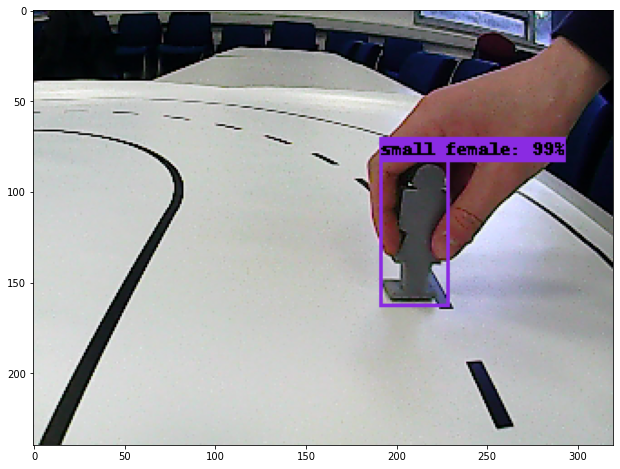

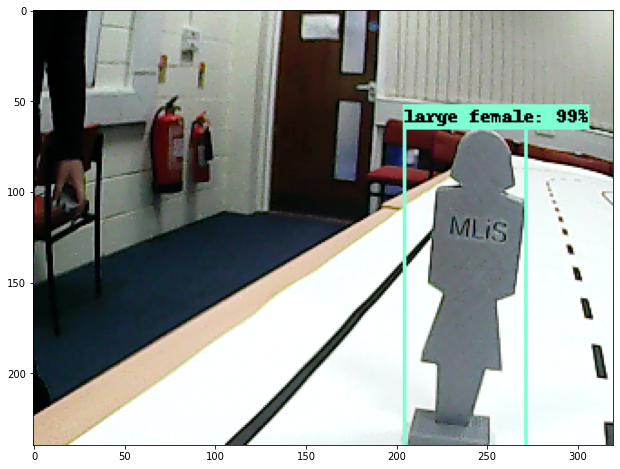

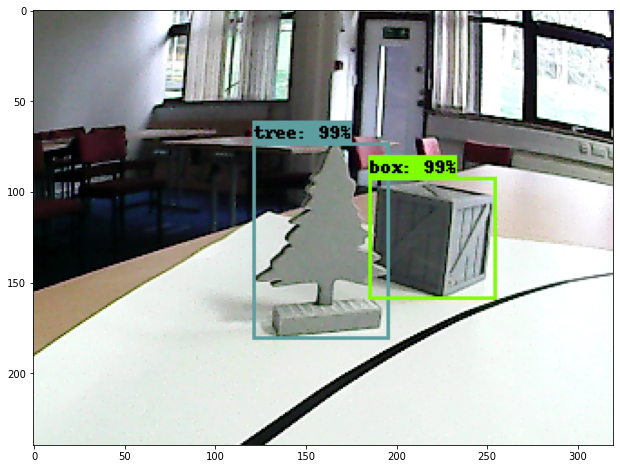

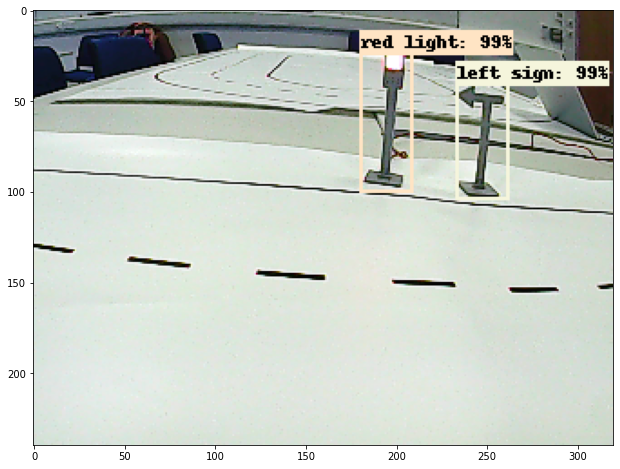

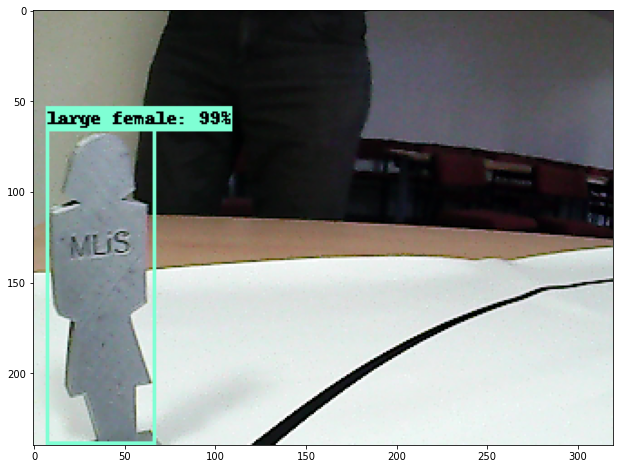

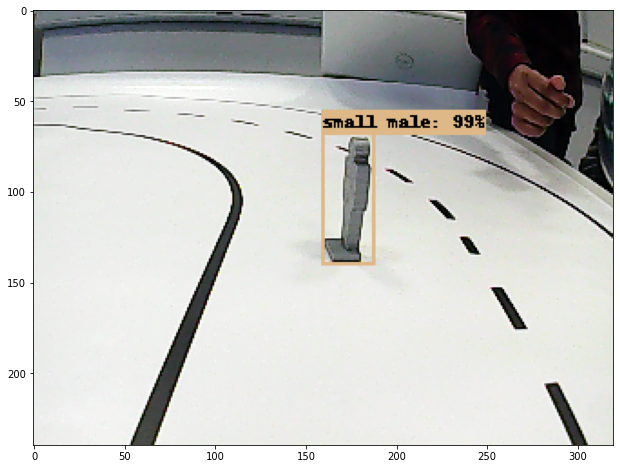

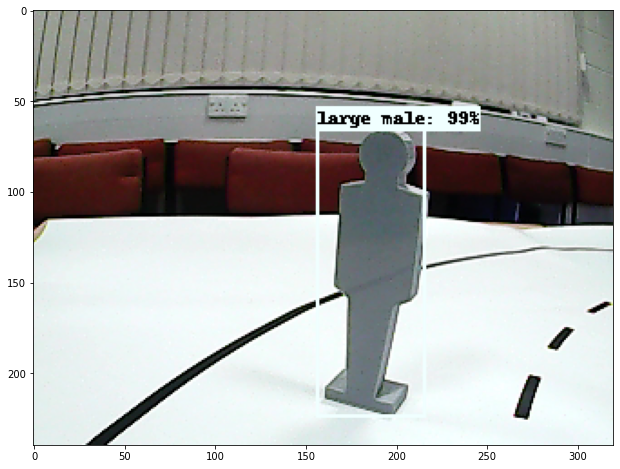

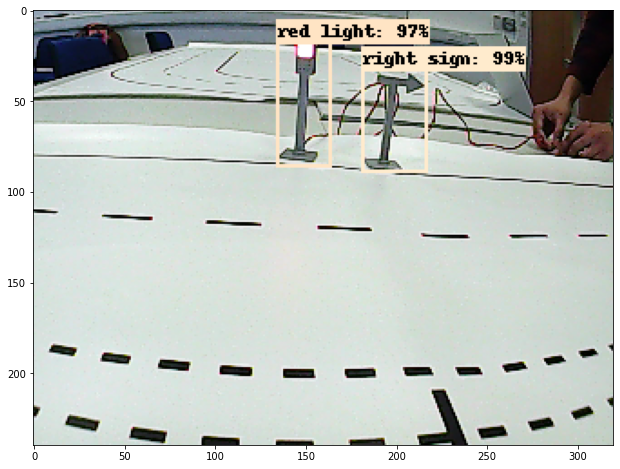

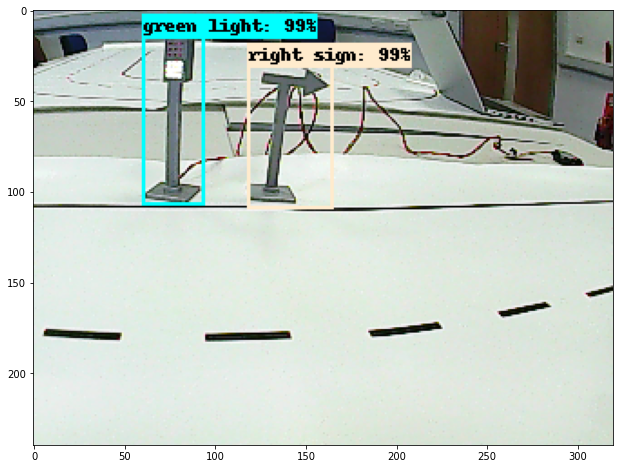

In [36]:
# running inferences.  This should show images with bounding boxes
%matplotlib inline

print('Running inferences on %s' % TEST_IMAGE_PATHS)
for image_path in TEST_IMAGE_PATHS[70:80]:
    #image_path=TEST_IMAGE_PATHS[0:20]
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=2)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)